# 02 — Neural Data Statistics

Overview of raw spike data properties: spike rate distributions, population sparsity, example rasters, tuning curve quality, and pairwise neuron correlations.

In [1]:
from remapping.dataset import (
    MiceDataset, Animals, GROUP_ORDER, SESSION_ORDER,
    SESSION_TYPE_MAP, EXPERIMENT_TYPE_ORDER, EXPERIMENT_TYPE_COLORS,
)
from remapping.plotting import PlotStyle, get_figures_path
from remapping.processing import smooth_tuning_curves_circularly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

mice = MiceDataset()
style = PlotStyle()
palette = mice.get_group_palette()

fig_path = get_figures_path("0.data_overview", "02_neural_data_statistics")

## Parameters

In [2]:
# Processing parameters (matching the standard pipeline)
ONLY_MOVING = True
BINS_COMPRESS = 3        # temporal binning factor (30.9 Hz → ~10.3 Hz)
BINS_SMOOTHING = 3       # Gaussian σ for firing rate smoothing
BINS_PHI = 360           # angular bins for tuning curves
TC_SMOOTH_KERNEL = 20    # circular smoothing kernel for tuning curves

# Example subject for raster plot
EXAMPLE_SUBJECT = Animals.M62

# Sampling rate after binning
FS_BINNED = 30.9 / BINS_COMPRESS  # ~10.3 Hz

## 1. Collect per-neuron spike statistics across all recordings

For each recording, compute the mean spike amplitude per neuron per time bin. This gives a distribution of activity levels across the dataset.

In [ ]:
neuron_stats = []  # one row per neuron per recording

for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    group = f"{info['genotype']}_{info['age']}"
    for fov in mice.get_available_fovs(subject):
        for session in mice.get_available_sessions(subject, fov):
            for run in mice.get_available_runs(subject, fov, session):
                spikes_b, phi_b, time_b, (cell_ids, _) = mice.load_spikes_binned(
                    subject, fov, session, run,
                    only_moving=ONLY_MOVING, bins_compress=BINS_COMPRESS,
                )
                n_bins = spikes_b.shape[0]
                duration_s = n_bins / FS_BINNED

                for j in range(spikes_b.shape[1]):
                    col = spikes_b[:, j]
                    neuron_stats.append({
                        "Subject": subject.value,
                        "Group": group,
                        "FOV": fov,
                        "Session": session,
                        "Run": run,
                        "Neuron": cell_ids[j],
                        "mean_spike": col.mean(),
                        "std_spike": col.std(),
                        "frac_active": (col > 0).mean(),
                        "max_spike": col.max(),
                        "n_bins": n_bins,
                        "duration_s": duration_s,
                    })

df_stats = pd.DataFrame(neuron_stats)
print(f"Total neuron x recording entries: {len(df_stats):,}")
df_stats.head()

Total neuron × recording entries: 63,924


,Subject,Group,FOV,Session,Run,Neuron,mean_spike,std_spike,frac_active,max_spike,n_bins,duration_s
0,m62,WT_old,2,fam1fam2,fam1,21,0.384758,2.093216,0.041746,33.016144,4719,458.15534
1,m62,WT_old,2,fam1fam2,fam1,192,0.019129,0.335092,0.005086,13.109334,4719,458.15534
2,m62,WT_old,2,fam1fam2,fam1,195,0.168775,1.020132,0.034965,23.903201,4719,458.15534
3,m62,WT_old,2,fam1fam2,fam1,196,0.251174,1.411836,0.043018,31.475641,4719,458.15534
4,m62,WT_old,2,fam1fam2,fam1,197,0.091050,0.808831,0.017588,22.526496,4719,458.15534


## 2. Mean spike amplitude distribution

Distribution of mean spike amplitude per neuron (after 3× temporal binning). Compared across genotype × age groups.

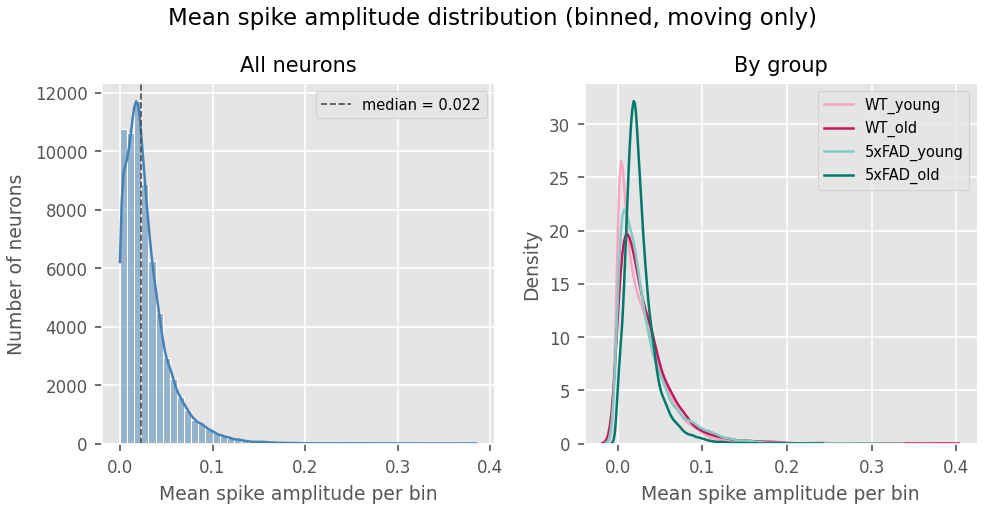

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(PlotStyle.FULL_WIDTH, 3.5))

# Left: overall distribution
sns.histplot(
    df_stats["mean_spike"], bins=50, kde=True,
    ax=axes[0], color="steelblue", edgecolor="white", linewidth=0.5,
)
axes[0].set_xlabel("Mean spike amplitude per bin")
axes[0].set_ylabel("Number of neurons")
axes[0].set_title("All neurons")
axes[0].axvline(df_stats["mean_spike"].median(), color="0.3", ls="--", lw=0.8,
                label=f'median = {df_stats["mean_spike"].median():.3f}')
axes[0].legend(fontsize=7)

# Right: by group (overlaid KDEs)
for group in GROUP_ORDER:
    subset = df_stats.loc[df_stats["Group"] == group, "mean_spike"]
    sns.kdeplot(subset, ax=axes[1], color=palette[group], label=group, lw=1.2)
axes[1].set_xlabel("Mean spike amplitude per bin")
axes[1].set_ylabel("Density")
axes[1].set_title("By group")
axes[1].legend(fontsize=7)

fig.suptitle("Mean spike amplitude distribution (binned, moving only)")
plt.tight_layout()
fig.savefig(fig_path / "mean_spike_distribution.pdf")
plt.show()

## 3. Population sparsity

For each time bin, what fraction of neurons are active (spike > 0)? This characterises how sparse the population code is.

In [5]:
# Compute per-recording population sparsity (mean fraction of active neurons per time bin)
sparsity_rows = []
for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    group = f"{info['genotype']}_{info['age']}"
    for fov in mice.get_available_fovs(subject):
        for session in mice.get_available_sessions(subject, fov):
            for run in mice.get_available_runs(subject, fov, session):
                spikes_b, _, _, _ = mice.load_spikes_binned(
                    subject, fov, session, run,
                    only_moving=ONLY_MOVING, bins_compress=BINS_COMPRESS,
                )
                # Fraction of neurons active per time bin
                frac_active_per_bin = (spikes_b > 0).mean(axis=1)  # (T,)
                sparsity_rows.append({
                    "Subject": subject.value,
                    "Group": group,
                    "Session": session,
                    "Run": run,
                    "mean_frac_active": frac_active_per_bin.mean(),
                    "std_frac_active": frac_active_per_bin.std(),
                })

df_sparsity = pd.DataFrame(sparsity_rows)
print(f"Recordings: {len(df_sparsity)}")
df_sparsity.describe()

Recordings: 321


,mean_frac_active,std_frac_active
count,321.000000,321.000000
mean,0.009957,0.008956
std,0.002686,0.002425
min,0.004553,0.004434
25%,0.008058,0.007281
50%,0.009408,0.008694
75%,0.011475,0.010364
max,0.018089,0.017170


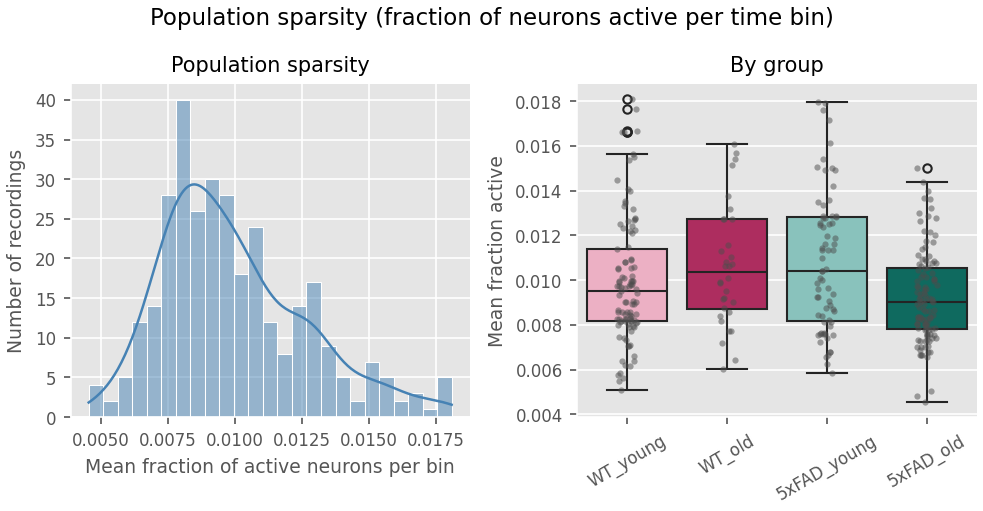

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(PlotStyle.FULL_WIDTH, 3.5))

# Left: histogram of mean population sparsity across recordings
sns.histplot(
    df_sparsity["mean_frac_active"], bins=25, kde=True,
    ax=axes[0], color="steelblue", edgecolor="white", linewidth=0.5,
)
axes[0].set_xlabel("Mean fraction of active neurons per bin")
axes[0].set_ylabel("Number of recordings")
axes[0].set_title("Population sparsity")

# Right: by group (boxplot + strip)
sns.boxplot(
    data=df_sparsity, x="Group", y="mean_frac_active", hue="Group",
    order=GROUP_ORDER, palette=palette, ax=axes[1], legend=False,
)
sns.stripplot(
    data=df_sparsity, x="Group", y="mean_frac_active",
    order=GROUP_ORDER, color=".3", size=3, ax=axes[1], alpha=0.5,
)
axes[1].set_xlabel("")
axes[1].set_ylabel("Mean fraction active")
axes[1].set_title("By group")
axes[1].tick_params(axis="x", rotation=30)

fig.suptitle("Population sparsity (fraction of neurons active per time bin)")
plt.tight_layout()
fig.savefig(fig_path / "population_sparsity.pdf")
plt.show()

## 4. Example raster plot

Raw spike raster for an example subject, showing 20 neurons over the first 60 seconds. Spike events are shown as dots with amplitude mapped to marker size.

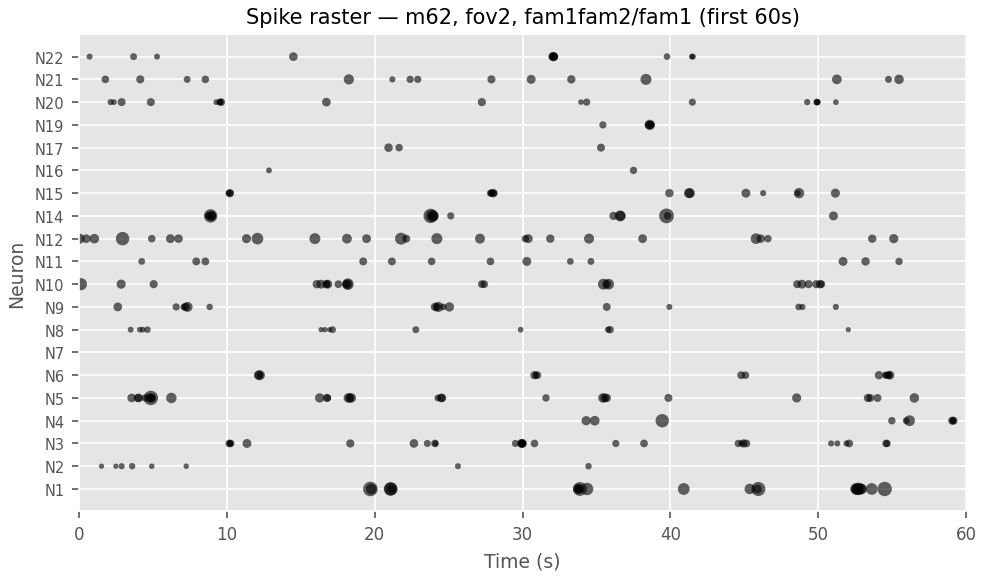

In [7]:
# Pick first available recording for the example subject
ex_fov = mice.get_available_fovs(EXAMPLE_SUBJECT)[0]
ex_sess = mice.get_available_sessions(EXAMPLE_SUBJECT, ex_fov)[0]
ex_run = mice.get_available_runs(EXAMPLE_SUBJECT, ex_fov, ex_sess)[0]

df_raw = mice.load_data(EXAMPLE_SUBJECT, ex_fov, ex_sess, ex_run)
cell_cols = [c for c in df_raw.columns if c.isdigit()]
time_s = df_raw["glob_time"].values - df_raw["glob_time"].values[0]

# Select first 60 seconds and 20 neurons
t_max = 60  # seconds
mask_t = time_s <= t_max
n_show = min(20, len(cell_cols))
sel_cells = cell_cols[:n_show]

spikes_raw = df_raw.loc[mask_t, sel_cells].values  # (T, 20)
time_show = time_s[mask_t]

fig, ax = plt.subplots(figsize=(PlotStyle.FULL_WIDTH, 4))
for i, cell in enumerate(sel_cells):
    t_spike = time_show[spikes_raw[:, i] > 0]
    amp = spikes_raw[spikes_raw[:, i] > 0, i]
    ax.scatter(t_spike, np.full_like(t_spike, i), s=amp * 3, c="k", alpha=0.6, linewidths=0)

ax.set_yticks(range(n_show))
ax.set_yticklabels([f"N{c}" for c in sel_cells], fontsize=7)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Neuron")
ax.set_title(f"Spike raster — {EXAMPLE_SUBJECT.value}, fov{ex_fov}, {ex_sess}/{ex_run} (first {t_max}s)")
ax.set_xlim(0, t_max)
plt.tight_layout()
fig.savefig(fig_path / "example_raster.pdf")
plt.show()

## 5. Tuning curve quality (selectivity index)

For each neuron, compute a selectivity index from its tuning curve: the ratio of peak to mean activity. High values indicate strong head-direction tuning. We compare distributions across groups.

In [8]:
# Compute selectivity index per neuron from tuning curves
selectivity_rows = []

for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    group = f"{info['genotype']}_{info['age']}"
    for fov in mice.get_available_fovs(subject):
        for session in mice.get_available_sessions(subject, fov):
            for run in mice.get_available_runs(subject, fov, session):
                fr, phi_b, _, (cell_ids, _), tc, phi_bins = (
                    mice.load_all_data_from_spikes_binned_smoothed(
                        subject, fov, session, run,
                        only_moving=ONLY_MOVING,
                        bins_compress=BINS_COMPRESS,
                        bins_smoothing=BINS_SMOOTHING,
                        bins_phi=BINS_PHI,
                    )
                )
                tc_smooth = smooth_tuning_curves_circularly(tc, TC_SMOOTH_KERNEL)

                for j in range(tc_smooth.shape[1]):
                    curve = tc_smooth[:, j]
                    mean_val = np.nanmean(curve)
                    peak_val = np.nanmax(curve)
                    selectivity = peak_val / mean_val if mean_val > 0 else 0.0
                    selectivity_rows.append({
                        "Subject": subject.value,
                        "Group": group,
                        "Session": session,
                        "Run": run,
                        "Neuron": cell_ids[j],
                        "selectivity": selectivity,
                        "peak": peak_val,
                        "mean_tc": mean_val,
                    })

df_sel = pd.DataFrame(selectivity_rows)
print(f"Neurons with tuning curves: {len(df_sel):,}")
df_sel.describe()

/Users/elenafaillace/Documents/all_code/manifold-remapping/src/remapping/dataset.py:398: RuntimeWarning: invalid value encountered in cast
  bin_idx = np.clip(np.floor((phi % 360) / dphi).astype(int), 0, n_points - 1)
/Users/elenafaillace/Documents/all_code/manifold-remapping/src/remapping/dataset.py:398: RuntimeWarning: invalid value encountered in cast
  bin_idx = np.clip(np.floor((phi % 360) / dphi).astype(int), 0, n_points - 1)
/Users/elenafaillace/Documents/all_code/manifold-remapping/src/remapping/dataset.py:398: RuntimeWarning: invalid value encountered in cast
  bin_idx = np.clip(np.floor((phi % 360) / dphi).astype(int), 0, n_points - 1)
/Users/elenafaillace/Documents/all_code/manifold-remapping/src/remapping/dataset.py:398: RuntimeWarning: invalid value encountered in cast
  bin_idx = np.clip(np.floor((phi % 360) / dphi).astype(int), 0, n_points - 1)


Neurons with tuning curves: 63,924


,selectivity,peak,mean_tc
count,63924.000000,63924.000000,63924.000000
mean,2.797219,0.125457,0.053999
std,1.874181,0.099693,0.043610
min,0.000000,0.000000,0.000000
25%,1.857488,0.060590,0.023552
50%,2.313243,0.096547,0.044254
75%,3.097950,0.160559,0.072107
max,18.000000,0.929354,0.462667


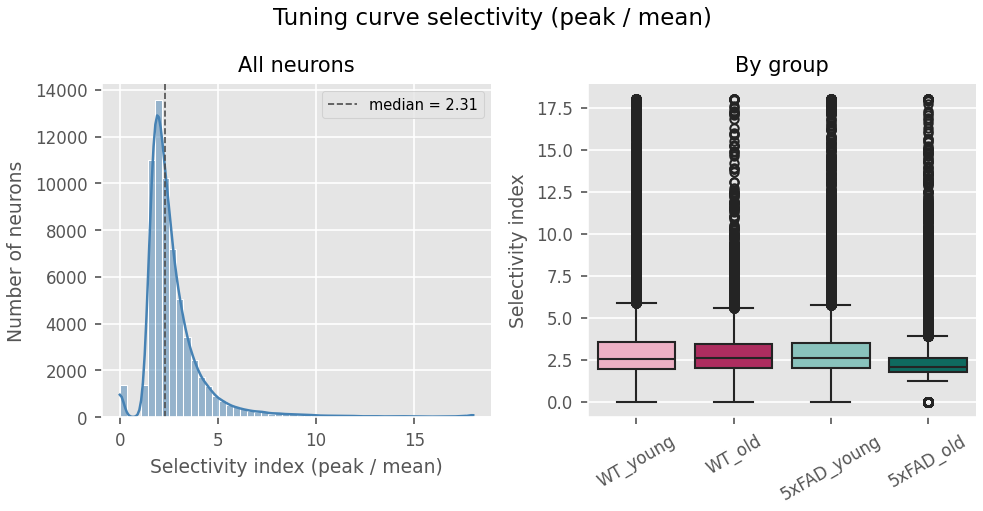

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(PlotStyle.FULL_WIDTH, 3.5))

# Left: overall histogram
sns.histplot(
    df_sel["selectivity"], bins=50, kde=True,
    ax=axes[0], color="steelblue", edgecolor="white", linewidth=0.5,
)
axes[0].set_xlabel("Selectivity index (peak / mean)")
axes[0].set_ylabel("Number of neurons")
axes[0].set_title("All neurons")
axes[0].axvline(df_sel["selectivity"].median(), color="0.3", ls="--", lw=0.8,
                label=f'median = {df_sel["selectivity"].median():.2f}')
axes[0].legend(fontsize=7)

# Right: by group
sns.boxplot(
    data=df_sel, x="Group", y="selectivity", hue="Group",
    order=GROUP_ORDER, palette=palette, ax=axes[1], legend=False,
)
axes[1].set_xlabel("")
axes[1].set_ylabel("Selectivity index")
axes[1].set_title("By group")
axes[1].tick_params(axis="x", rotation=30)

fig.suptitle("Tuning curve selectivity (peak / mean)")
plt.tight_layout()
fig.savefig(fig_path / "tuning_selectivity.pdf")
plt.show()

## 6. Pairwise neuron correlations

Distribution of pairwise Pearson correlations between neuron spike trains (after binning), sampled from one recording per group. This shows how structured the population activity is.

In [10]:
# Collect pairwise correlations from one recording per group
corr_data = []

for group in GROUP_ORDER:
    genotype, age = group.split("_")
    subjects = mice.get_subjects_by_group(genotype, age)
    # Pick first subject, first fov, first session, first run
    s = subjects[0]
    fov = mice.get_available_fovs(s)[0]
    sess = mice.get_available_sessions(s, fov)[0]
    run = mice.get_available_runs(s, fov, sess)[0]

    spikes_b, _, _, _ = mice.load_spikes_binned(
        s, fov, sess, run,
        only_moving=ONLY_MOVING, bins_compress=BINS_COMPRESS,
    )
    # Pairwise Pearson correlation (upper triangle only)
    C = np.corrcoef(spikes_b.T)
    iu = np.triu_indices(C.shape[0], k=1)
    vals = C[iu]
    vals = vals[np.isfinite(vals)]

    for v in vals:
        corr_data.append({"Group": group, "correlation": v})

df_corr = pd.DataFrame(corr_data)
print(f"Total pairwise correlations: {len(df_corr):,}")

/Users/elenafaillace/Documents/all_code/manifold-remapping/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/elenafaillace/Documents/all_code/manifold-remapping/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/elenafaillace/Documents/all_code/manifold-remapping/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/elenafaillace/Documents/all_code/manifold-remapping/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Total pairwise correlations: 122,995


/Users/elenafaillace/Documents/all_code/manifold-remapping/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/elenafaillace/Documents/all_code/manifold-remapping/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


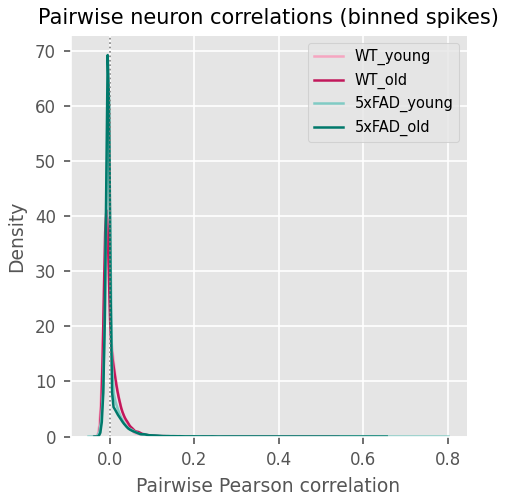

In [11]:
fig, ax = plt.subplots(figsize=(PlotStyle.HALF_WIDTH, 3.5))

for group in GROUP_ORDER:
    subset = df_corr.loc[df_corr["Group"] == group, "correlation"]
    sns.kdeplot(subset, ax=ax, color=palette[group], label=group, lw=1.2)

ax.axvline(0, color="0.5", ls=":", lw=0.8)
ax.set_xlabel("Pairwise Pearson correlation")
ax.set_ylabel("Density")
ax.set_title("Pairwise neuron correlations (binned spikes)")
ax.legend(fontsize=7)
plt.tight_layout()
fig.savefig(fig_path / "pairwise_correlations.pdf")
plt.show()